<a href="https://colab.research.google.com/github/abracadabrabrabra/ml_labs-homework/blob/main/hw3_unsupervised_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

sns.set_theme(style='darkgrid')
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir_path = "/content/drive/MyDrive/ml_hw3/datasets/UCI_HAR_Dataset/"
X_train = np.loadtxt(dir_path + "train/X_train.txt")
y_train = np.loadtxt(dir_path + "train/y_train.txt").astype(int)

X_test = np.loadtxt(dir_path + "test/X_test.txt")
y_test = np.loadtxt(dir_path + "test/y_test.txt").astype(int)

In [ ]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [ ]:
# Ваш код здесь
X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))

print(f"Размер X_train: {X_train.shape}")
print(f"Размер X_test: {X_test.shape}")
print(f"Общий размер X: {X.shape}")
print(f"Размер y: {y.shape}")

Размер X_train: (7352, 561)
Размер X_test: (2947, 561)
Общий размер X: (10299, 561)
Размер y: (10299,)


Определим число уникальных значений меток целевого класса.

In [ ]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [ ]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [ ]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Размер X_scaled: {X_scaled.shape}")
print(f"Среднее по столбцам после масштабирования: {X_scaled.mean(axis=0)[:5]}")
print(f"Стандартное отклонение по столбцам: {X_scaled.std(axis=0)[:5]}")

Размер X_scaled: (10299, 561)
Среднее по столбцам после масштабирования: [ 5.52841263e-15 -1.38651383e-15 -5.28337448e-15 -2.21336365e-15
  4.63827227e-16]
Стандартное отклонение по столбцам: [1. 1. 1. 1. 1.]


Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [ ]:
# Ваш код здесь
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

print(f"Размер X_pca: {X_pca.shape}")
print(f"Объясненная дисперсия: {sum(pca.explained_variance_ratio_):.4f}")

Размер X_pca: (10299, 65)
Объясненная дисперсия: 0.9005


**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- 65
- 66
- 193

Ответ: 65

In [ ]:
print(f"Количество компонент, объясняющих 90% дисперсии: {pca.n_components_}")

Количество компонент, объясняющих 90% дисперсии: 65


**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- 51
- 56
- 61

Ответ: 51

In [ ]:
first_component_variance = pca.explained_variance_ratio_[0]
percentage = round(first_component_variance * 100)
print(f"Процент дисперсии для первой главной компоненты: {percentage}%")

Процент дисперсии для первой главной компоненты: 51%


Визуализируйте данные в проекции на первые две главные компоненты.

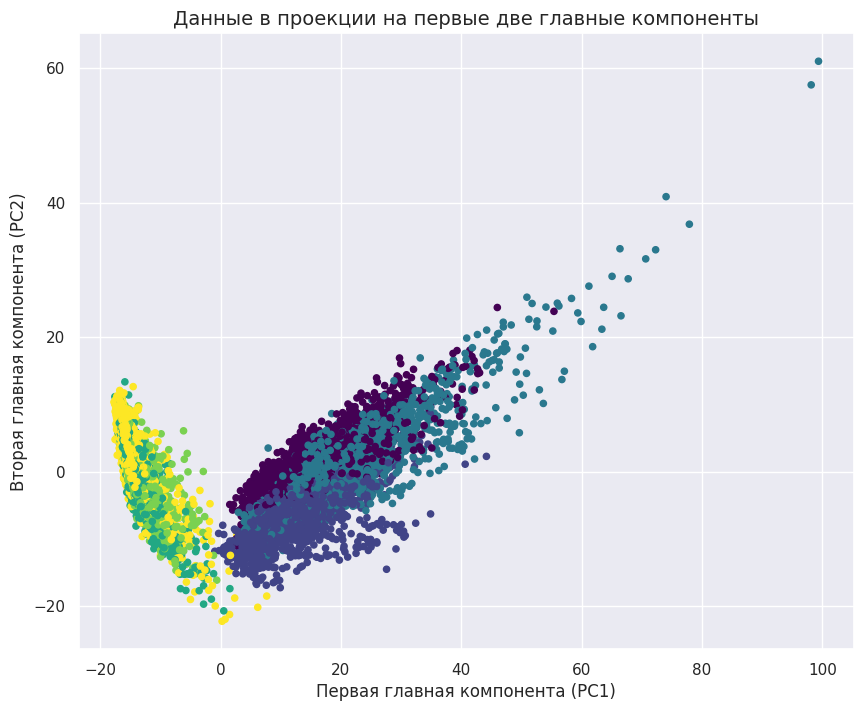

In [ ]:
# Ваш код здесь
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                     c=y, s = 20, cmap='viridis')

plt.xlabel('Первая главная компонента (PC1)', fontsize=12)
plt.ylabel('Вторая главная компонента (PC2)', fontsize=12)
plt.title('Данные в проекции на первые две главные компоненты', fontsize=14)
plt.show()

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [ ]:
# Ваш код здесь
from scipy.spatial.distance import cdist

class MyKMeans:
    def __init__(self, n_clusters=8, n_init=10, max_iter=300, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None

    def fit(self, X):
        np.random.seed(self.random_state)
        best_inertia = np.inf
        best_centers = None
        best_labels = None

        for init in range(self.n_init):
            centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

            for iteration in range(self.max_iter):
                distances = cdist(X, centroids, 'euclidean')
                labels = np.argmin(distances, axis=1)
                new_centroids = np.array([X[labels == i].mean(axis=0)
                                         for i in range(self.n_clusters)])

                if np.all(np.linalg.norm(new_centroids - centroids, axis=1) < self.tol):
                    break

                centroids = new_centroids

            inertia = np.sum([np.sum((X[labels == i] - centroids[i])**2)
                            for i in range(self.n_clusters)])

            if inertia < best_inertia:
                best_inertia = inertia
                best_centers = centroids
                best_labels = labels

        self.cluster_centers_ = best_centers
        self.labels_ = best_labels
        self.inertia_ = best_inertia

        return self

    def predict(self, X):
        distances = cdist(X, self.cluster_centers_, 'euclidean')
        return np.argmin(distances, axis=1)



n_clusters = len(np.unique(y))

my_kmeans = MyKMeans(n_clusters=n_clusters, n_init=100, random_state=RANDOM_STATE)
my_kmeans.fit(X_pca)
my_labels = my_kmeans.labels_
my_inertia = my_kmeans.inertia_

print("=== My KMeans ===")
print(f"Количество кластеров: {n_clusters}")
print(f"Инерция (inertia): {my_inertia:.2f}")
print(f"Размер labels: {my_labels.shape}")
print(f"Уникальные метки кластеров: {np.unique(my_labels)}")

from sklearn.cluster import KMeans

sklearn_kmeans = KMeans(n_clusters=n_clusters, n_init=100, random_state=RANDOM_STATE)
sklearn_kmeans.fit(X_pca)
sklearn_labels = sklearn_kmeans.labels_
sklearn_inertia = sklearn_kmeans.inertia_

print("\n=== Sklearn KMeans ===")
print(f"Инерция (inertia): {sklearn_inertia:.2f}")
print(f"Размер labels: {sklearn_labels.shape}")
print(f"Уникальные метки кластеров: {np.unique(sklearn_labels)}")

print("\n=== Compare results ===")
print(f"Разница в инерции: {abs(my_inertia - sklearn_inertia):.2f}")

=== My KMeans ===
Количество кластеров: 6
Инерция (inertia): 2003454.20
Размер labels: (10299,)
Уникальные метки кластеров: [0 1 2 3 4 5]

=== Sklearn KMeans ===
Инерция (inertia): 2003454.90
Размер labels: (10299,)
Уникальные метки кластеров: [0 1 2 3 4 5]

=== Compare results ===
Разница в инерции: 0.70


Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

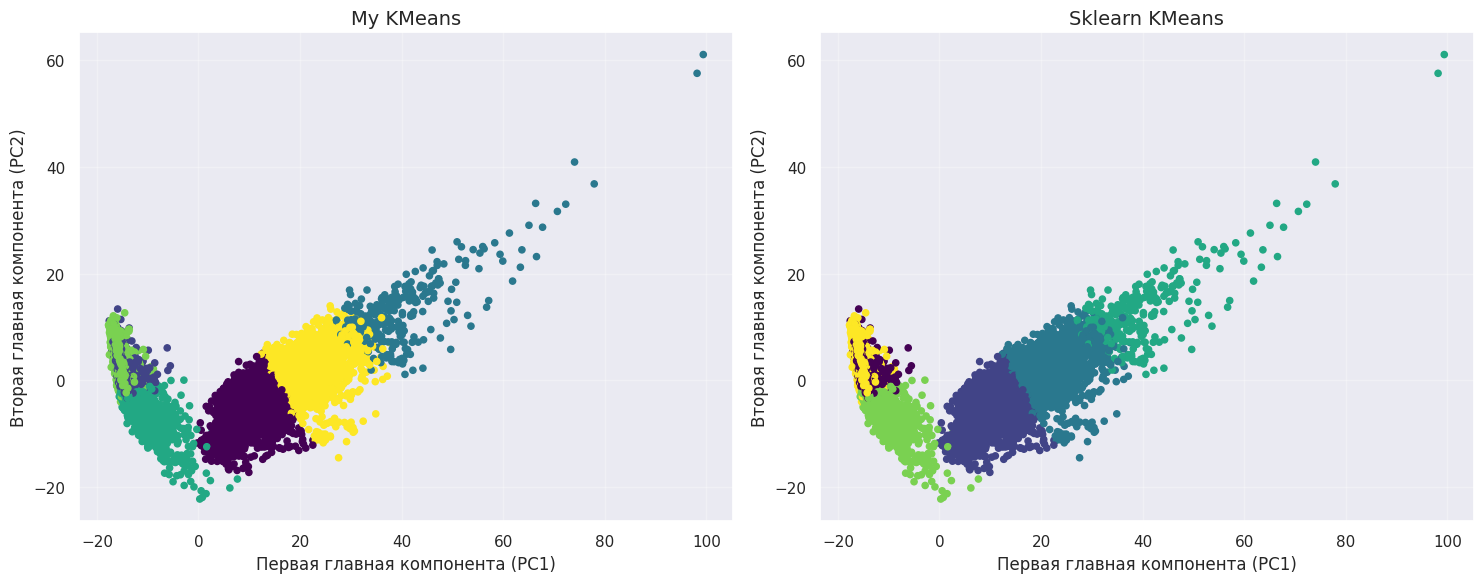

In [ ]:
# Ваш код здесь
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# My KMeans
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=my_labels, s=20, cmap='viridis')
axes[0].set_xlabel('Первая главная компонента (PC1)', fontsize=12)
axes[0].set_ylabel('Вторая главная компонента (PC2)', fontsize=12)
axes[0].set_title('My KMeans', fontsize=14)
axes[0].grid(True, alpha=0.3)

# klearn KMeans
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=sklearn_labels, s=20, cmap='viridis')
axes[1].set_xlabel('Первая главная компонента (PC1)', fontsize=12)
axes[1].set_ylabel('Вторая главная компонента (PC2)', fontsize=12)
axes[1].set_title('Sklearn KMeans', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [ ]:
tab = pd.crosstab(y, my_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,901,0,78,0,0,743,1722
подъем вверх по лестнице,1239,0,5,2,0,298,1544
спуск по лестнице,319,0,196,0,0,891,1406
сидение,1,1235,0,450,91,0,1777
стояние,0,1344,0,562,0,0,1906
лежание,5,52,0,329,1558,0,1944
все,2465,2631,279,1343,1649,1932,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- перечисленные варианты не подходят

Ответ: перечисленные варианты не подходят

In [ ]:
data = {
    'cluster1': [901, 1239, 319, 1, 0, 5, 2465],
    'cluster2': [0, 0, 0, 1235, 1344, 52, 2631],
    'cluster3': [78, 5, 196, 0, 0, 0, 279],
    'cluster4': [0, 2, 0, 450, 562, 329, 1343],
    'cluster5': [0, 0, 0, 91, 0, 1558, 1649],
    'cluster6': [743, 298, 891, 0, 0, 0, 1932],
    'все': [1722, 1544, 1406, 1777, 1906, 1944, 10299]
}

index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
         'сидение', 'стояние', 'лежание', 'все']

tab = pd.DataFrame(data, index=index)

max_fractions = {}
for activity in tab.index[:-1]:
    total = tab.loc[activity, 'все']

    cluster_counts = tab.loc[activity, ['cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6']]
    max_count = cluster_counts.max()
    max_fraction = max_count / total
    max_fractions[activity] = max_fraction

    max_cluster = cluster_counts.idxmax()

best_activity = max(max_fractions, key=max_fractions.get)
best_fraction = max_fractions[best_activity]

print(f"ЛУЧШЕ ВСЕГО ОТДЕЛЯЕТСЯ: {best_activity.upper()}")
print(f"Максимальная доля: {best_fraction:.3f}")

ЛУЧШЕ ВСЕГО ОТДЕЛЯЕТСЯ: ПОДЪЕМ ВВЕРХ ПО ЛЕСТНИЦЕ
Максимальная доля: 0.802


Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

In [ ]:
# Ваш код здесь
from tqdm.auto import tqdm
inertia = []
n_init = 100
k_values = range(1, n_classes + 1)
for k in tqdm(k_values, desc="Вычисление инерции"):
    kmeans = KMeans(n_clusters=k, n_init=n_init, random_state=RANDOM_STATE)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

Вычисление инерции:   0%|          | 0/6 [00:00<?, ?it/s]

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- 2
- 3
- 4

Ответ: 2.

------------------------

([<matplotlib.axis.XTick at 0x7a5a192ae9f0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6')])

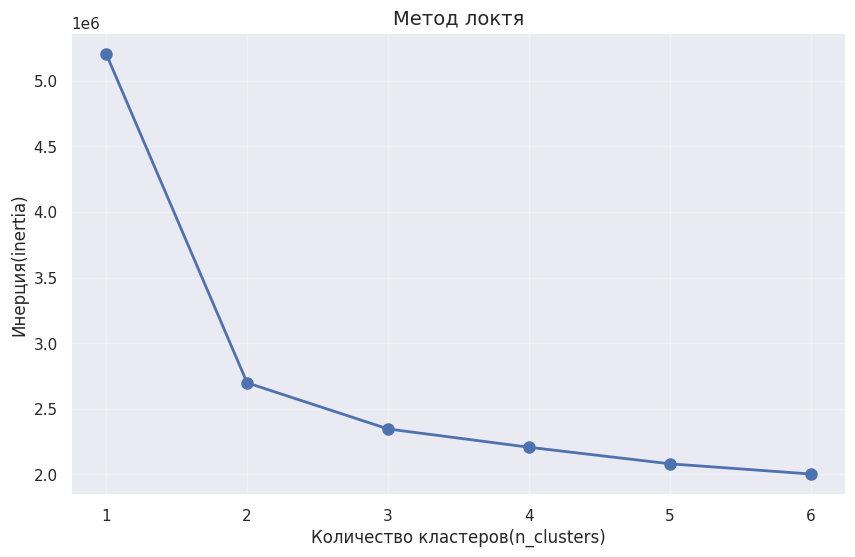

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Количество кластеров(n_clusters)', fontsize=12)
plt.ylabel('Инерция(inertia)', fontsize=12)
plt.title('Метод локтя', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(k_values)

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [ ]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [ ]:
from sklearn.metrics import adjusted_rand_score
ag_labels = ag.fit_predict(X_pca)
kmeans_labels = sklearn_kmeans.labels_
ari_ag = adjusted_rand_score(y, ag_labels)
ari_kmeans = adjusted_rand_score(y, kmeans_labels)
print(ari_kmeans, ari_ag)

0.4198070012602345 0.49362763373004886


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю

Все утверждения верны. Касаемо первого: ari_ag > ari_kmeans => у ag лучше соответствие истинным классам.

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [ ]:
# Ваш код здесь
#
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [ ]:
# Ваш код здесь
from sklearn.model_selection import GridSearchCV

best_svc = GridSearchCV(svc, svc_params, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
best_svc.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


GridSearchCV(cv=3, estimator=LinearSVC(random_state=17), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]}, scoring='accuracy',
             verbose=1)

In [ ]:
# Ваш код здесь
print(best_svc.best_estimator_)
print(best_svc.best_params_)
print(best_svc.best_score_)

LinearSVC(C=0.1, random_state=17)
{'C': 0.1}
0.9379785010699506


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- 0.1
- 1
- 10

Ответ: 0.1

In [ ]:
y_predicted = best_svc.predict(X_test_scaled)

In [ ]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- по точности – сидение, по полноте – стояние

Ответ: по точности - стояние, по полноте - сидение.

In [ ]:
data = {
    'ходьба': [494, 12, 2, 0, 0, 0],
    'подъем вверх по лестнице': [2, 459, 4, 4, 0, 0],
    'спуск по лестнице': [0, 0, 413, 0, 0, 0],
    'сидение': [0, 0, 1, 426, 15, 0],
    'стояние': [0, 0, 0, 61, 517, 11],
    'лежание': [0, 0, 0, 0, 0, 526]
}

index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
         'сидение', 'стояние', 'лежание']

df = pd.DataFrame(data, index=index)
df['все'] = df.sum(axis=1)
df.loc['все'] = df.sum(axis=0)
results = []

for activity in index:
    tp = df.loc[activity, activity]

    predicted_total = df.loc[index, activity].sum()
    actual_total = df.loc[activity, 'все']

    # (Precision) = TP / (TP + FP)
    if predicted_total > 0:
        precision = tp / predicted_total
    else:
        precision = 0

    # (Recall) = TP / (TP + FN)
    recall = tp / actual_total

    results.append({
        'Активность': activity,
        'TP': tp,
        'Всего предсказано': predicted_total,
        'Всего истинных': actual_total,
        'Точность (Precision)': precision,
        'Полнота (Recall)': recall
    })

results_df = pd.DataFrame(results)
print("Метрики для каждого класса:")
print(results_df.to_string(index=False))

Метрики для каждого класса:
              Активность  TP  Всего предсказано  Всего истинных  Точность (Precision)  Полнота (Recall)
                  ходьба 494                508             496              0.972441          0.995968
подъем вверх по лестнице 459                469             471              0.978678          0.974522
       спуск по лестнице 413                413             420              1.000000          0.983333
                 сидение 426                442             491              0.963801          0.867617
                 стояние 517                589             532              0.877759          0.971805
                 лежание 526                526             537              1.000000          0.979516


In [ ]:
import time
from sklearn.decomposition import PCA

# without PCA
start = time.time()
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

grid_no_pca = GridSearchCV(
    LinearSVC(random_state=17, max_iter=10000),
    {'C': [0.001, 0.01, 0.1, 1, 10]},
    cv=3, n_jobs=-1
).fit(X_train_s, y_train)
time_no_pca = time.time() - start

# with PCA
start = time.time()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

pca = PCA(n_components=0.9, random_state=17)
X_train_pca = pca.fit_transform(X_train_s)
X_test_pca = pca.transform(X_test_s)

grid_pca = GridSearchCV(
    LinearSVC(random_state=17, max_iter=10000),
    {'C': [0.001, 0.01, 0.1, 1, 10]},
    cv=3, n_jobs=-1
).fit(X_train_pca, y_train)
time_pca = time.time() - start

print(f"Без PCA: {time_no_pca:.2f} сек, точность CV: {grid_no_pca.best_score_:.4f}")
print(f"С PCA:   {time_pca:.2f} сек, точность CV: {grid_pca.best_score_:.4f}")
print(f"Ускорение: {time_no_pca/time_pca:.2f}x, компонент: {pca.n_components_}")

Без PCA: 160.96 сек, точность CV: 0.9380
С PCA:   6.42 сек, точность CV: 0.8984
Ускорение: 25.08x, компонент: 63


Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- 4%
- 10%
- 20%


Ответ: 4%.

In [ ]:
print(f"{((grid_no_pca.best_score_ - grid_pca.best_score_) / grid_pca.best_score_ * 100):.4f}%")

4.4056%


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком

Верные ответы: 2 (O(n) - PCA, O(n^2) - tSNE), 3.

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

После PCA: (10299, 50)
После t-SNE: (10299, 2)

АНАЛИЗ РЕЗУЛЬТАТОВ
Уникальные метки: [-1  0  1  2  3  4  5]
Количество кластеров: 6
Количество шума: 2 (0.0%)

Распределение по кластерам:
-1       2
 0    5619
 1    4423
 2      53
 3      24
 4     124
 5      54
Name: count, dtype: int64

Silhouette Score (без шума): 0.1120

Adjusted Rand Index (со шумом): 0.3259


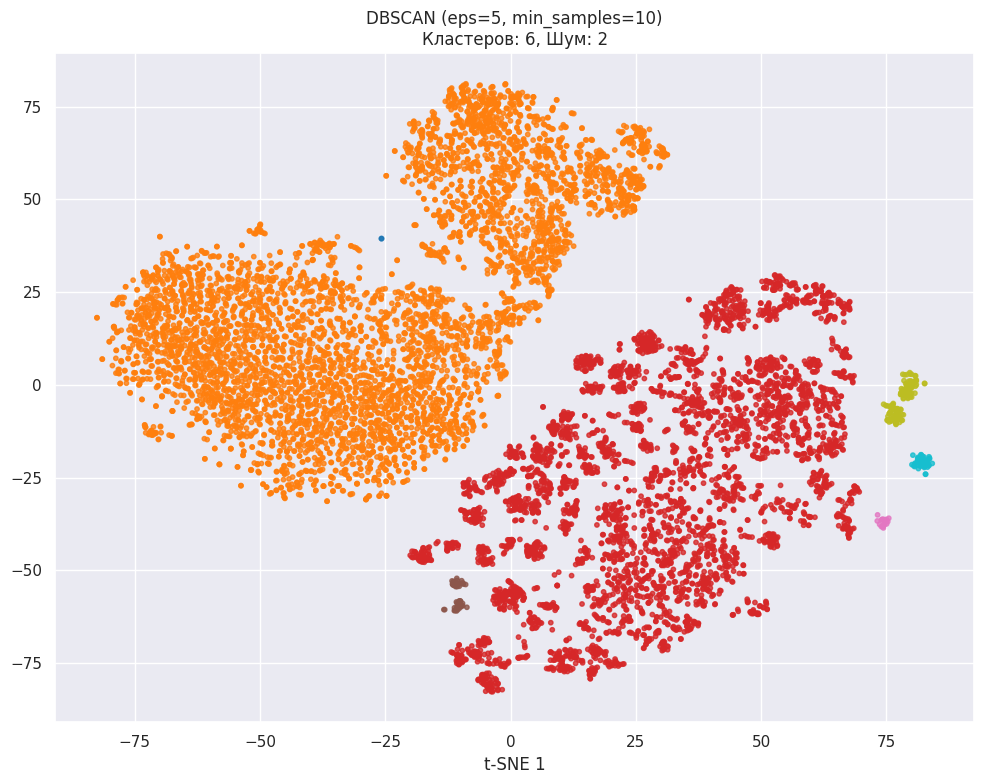

In [ ]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score

pca_tsne = PCA(n_components=50, random_state=RANDOM_STATE)
X_tsne_input = pca_tsne.fit_transform(X_scaled)
print(f"После PCA: {X_tsne_input.shape}")

tsne = TSNE(n_components=2, random_state=RANDOM_STATE,
            perplexity=40, learning_rate="auto", init="random")
X_tsne = tsne.fit_transform(X_tsne_input)
print(f"После t-SNE: {X_tsne.shape}")
dbscan = DBSCAN(eps=5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_tsne)

print("\n" + "="*60)
print("АНАЛИЗ РЕЗУЛЬТАТОВ")
print("="*60)

unique_labels = np.unique(dbscan_labels)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_noise = np.sum(dbscan_labels == -1)

print(f"Уникальные метки: {unique_labels}")
print(f"Количество кластеров: {n_clusters}")
print(f"Количество шума: {n_noise} ({n_noise/len(dbscan_labels)*100:.1f}%)")

cluster_dist = pd.Series(dbscan_labels).value_counts().sort_index()
print(f"\nРаспределение по кластерам:")
print(cluster_dist)
if n_clusters > 1 and -1 in unique_labels:
    mask = dbscan_labels != -1
    if np.sum(mask) > 0 and len(np.unique(dbscan_labels[mask])) > 1:
        from sklearn.metrics import silhouette_score
        silhouette = silhouette_score(X_tsne[mask], dbscan_labels[mask])
        print(f"\nSilhouette Score (без шума): {silhouette:.4f}")

ari = adjusted_rand_score(y, dbscan_labels)
print(f"\nAdjusted Rand Index (со шумом): {ari:.4f}")

plt.figure(figsize=(10, 8))
# DBSCAN
scatter1 = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
                          c=dbscan_labels, cmap='tab10', s=10, alpha=0.8)
plt.title(f'DBSCAN (eps=5, min_samples=10)\nКластеров: {n_clusters}, Шум: {n_noise}')
plt.xlabel('t-SNE 1')

plt.tight_layout()
plt.show()